In [8]:
'''
Made price into bins
'''

## import packages
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import pandas as pd
import tensorflow as tf
import collections
import random
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import nltk
import itertools
import matplotlib.pyplot as plt
import re

In [9]:
## import data 
start_time = time.time()

train_raw = pd.read_csv('/home/bsong/Python_Stuff/Data/Kaggle_Mercari/train.tsv',delimiter= '\t')
test_raw = pd.read_csv('/home/bsong/Python_Stuff/Data/Kaggle_Mercari/test.tsv', delimiter='\t')
#train_raw = train_raw.iloc[0:10000,] # just a bit
# standardize price here because may as well
#normalized_price = np.log1p(train_raw['price'].values)
#mean_price_norm = np.mean(normalized_price)
#std_price_norm = np.std(normalized_price) 
#train_raw['price'] = (normalized_price - mean_price_norm)/std_price_norm 

end_time = time.time()
print('import data took ' + str(end_time - start_time) + " seconds.")

import data took 6.030135631561279 seconds.


In [10]:
## bin price one method

binsize_sub200 = 10
binsize_200_1000 = 10
binsize_sup1000 = 15

total_bins = binsize_sub200 + binsize_200_1000 + binsize_sup1000

inds_sub200 = train_raw.train_id[train_raw.price <= 200].values
inds_200_1000 = train_raw.train_id[(train_raw.price > 200) & (train_raw.price <= 1000)].values
inds_sup1000 = train_raw.train_id[train_raw.price > 1000].values

price_sub200 = train_raw.price[train_raw.price <= 200].values
price_200_1000 = train_raw.price[(train_raw.price > 200) & (train_raw.price <= 1000)].values
price_sup1000 = train_raw.price[train_raw.price > 1000].values

bins_sub200 = np.linspace(1, 200, binsize_sub200)
bins_200_1000 = np.linspace(200,1000, binsize_200_1000)
bins_sup1000 = np.linspace(1000, np.max(train_raw.price.values), binsize_sup1000)

price_bins_sub200 = np.digitize(price_sub200, bins_sub200)
price_bins_200_1000 = np.digitize(price_200_1000, bins_200_1000)
price_bins_sup1000 = np.digitize(price_sup1000, bins_sup1000)
#bin_means_sub_1000 = [train_raw.price.values[bins_sub1000 == i].mean() for i in range(1, len(bins))]

bin_mean_sub200 = np.array([price_sub200[price_bins_sub200 == i].mean() for i in range(1, binsize_sub200+1)])
bin_mean_200_1000 = np.array([price_200_1000[price_bins_200_1000 == i].mean() for i in range(1,binsize_200_1000+1)])
bin_mean_sup1000 = np.array([price_sup1000[price_bins_sup1000 == i].mean() for i in range(1, binsize_sup1000+1)])

bin_std_sub200 = [price_sub200[price_bins_sub200 == i].std() for i in range(1, binsize_sub200+1)]
bin_std_200_1000 = [price_200_1000[price_bins_200_1000 == i].std() for i in range(1,binsize_200_1000+1)]
bin_std_sup1000 = [price_sup1000[price_bins_sup1000 == i].std() for i in range(1, binsize_sup1000+1)]

train_raw['price_bins'] = [0]*train_raw.shape[0]
train_raw['price_bins_mean'] = [0]*train_raw.shape[0]

train_raw.price_bins.iloc[inds_sub200] = price_bins_sub200
train_raw.price_bins.iloc[inds_200_1000] = price_bins_200_1000 + binsize_sub200
train_raw.price_bins.iloc[inds_sup1000] = price_bins_sup1000 + binsize_sub200 + binsize_200_1000

train_raw.price_bins_mean.iloc[inds_sub200] = bin_mean_sub200[price_bins_sub200-1]
train_raw.price_bins_mean.iloc[inds_200_1000] = bin_mean_200_1000[price_bins_200_1000-1]
train_raw.price_bins_mean.iloc[inds_sup1000] = bin_mean_sup1000[price_bins_sup1000-1]

/home/bsong/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [34]:
## bin price another method
sort_price = sorted(train_raw.price.values)
perc1 = np.percentile(sort_price,25)
perc2 = np.percentile(sort_price,75)
perc3 = np.percentile(sort_price,90)
perc4 = np.percentile(sort_price,98)

total_bins = 5
inds1 = train_raw.train_id[train_raw.price <= perc1].values
inds2 = train_raw.train_id[(train_raw.price > perc1) & (train_raw.price <= perc2)].values
inds3 = train_raw.train_id[(train_raw.price > perc2) & (train_raw.price <= perc3)].values
inds4 = train_raw.train_id[(train_raw.price > perc3) & (train_raw.price <= perc4)].values
inds5 = train_raw.train_id[(train_raw.price > perc4)].values 

price_1 = train_raw.price[train_raw.price <= perc1].values
price_2 = train_raw.price[(train_raw.price > perc1) & (train_raw.price <= perc2)].values
price_3 = train_raw.price[(train_raw.price > perc2) & (train_raw.price <= perc3)].values
price_4 = train_raw.price[(train_raw.price > perc3) & (train_raw.price <= perc4)].values
price_5 = train_raw.price[train_raw.price > perc4].values

train_raw['price_bins'] = [0]*train_raw.shape[0]
train_raw['price_bins_mean'] = [0]*train_raw.shape[0]

train_raw.price_bins.iloc[inds1] = 1
train_raw.price_bins.iloc[inds2] = 2
train_raw.price_bins.iloc[inds3] = 3
train_raw.price_bins.iloc[inds4] = 4
train_raw.price_bins.iloc[inds5] = 5

train_raw.price_bins_mean.iloc[inds1] = price_1.mean()
train_raw.price_bins_mean.iloc[inds2] = price_2.mean()
train_raw.price_bins_mean.iloc[inds3] = price_3.mean()
train_raw.price_bins_mean.iloc[inds4] = price_4.mean()
train_raw.price_bins_mean.iloc[inds5] = price_5.mean()

/home/bsong/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [35]:
print([perc1,perc2,perc3, perc4])

[10.0, 29.0, 51.0, 122.0]


In [18]:
## define functions to use

######## Basic text manipulation functions (some specific to Mercari Kaggle Competition) 

def split_cat(text): # this one is to reduce the categoriy_name into three subcategories
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

def handle_missing_inplace(dataset):  # this one is to put placeholders in place of missing values (NaN)
    dataset['cat1'].fillna(value='No Label', inplace=True)
    dataset['cat2'].fillna(value='No Label', inplace=True)
    dataset['cat3'].fillna(value='No Label', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].fillna(value='No description yet', inplace=True)
     
def build_dictionary(words, n_words): # dictionary that maps words to indices. this function should be modular.
    #input is [['a','b','c'],['a','b','c']]
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]] # word indexed as "unknown" if not one of the top #n_words (popular/common) words (-1 is filler #)
    count.extend(Counter(words).most_common(n_words - 1)) # most_common returns the top (n_words-1) ['word',count]
    dictionary = dict()
    for word, _ in count: # the 'word, _' is writted because count is a list of list(2), so defining 'word' as the first term per
        dictionary[word] = len(dictionary) # {'word': some number incrementing by one. fyi, no repeats because from most_common)}
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys())) # {ind. : 'word'} I guess for looking up if needed?
    return dictionary, reversed_dictionary

def clean_and_tokenize(dataset_col): # input is a column of strings
    pattern = '[A-Za-z]+' # does this only keep words
    pattern2 = '[!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n]' # to rid of special characters
    list_of_lists = list()
    tokenizer = RegexpTokenizer(pattern)
    words_to_remove = ['description', 'yet','like','the','any','they']
    words_to_remove.extend(stopwords.words('english'))
    words_to_remove = set(words_to_remove)
    
    for word in dataset_col:
        list_of_words = list()
        word = re.sub(pattern2, r'', word)
        tokenized = tokenizer.tokenize(word)
        tokenized_filtered = filter(lambda token: token not in words_to_remove, tokenized)
        for i in tokenized_filtered:
            if (len(i) > 2 ): #ignore words of length 2 or less
                list_of_words.append(i.lower()) # append all words to one list
        list_of_lists.append(list_of_words)
    list_as_series = pd.Series(list_of_lists)
    return list_as_series

def convert_word_to_ind(dataset_col,dictionary): # input the pandas column of texts and dictionary. This should be modular
    # each input should be a string of cleaned words tokenized into a list (ex. ['this', 'is', 'an', 'item'])
    # dictionary should be the dictionary obtained from build_dictionary
    list_of_lists = []
    unk_count = 0 # total 'unknown' words counted
    for word_or_words in dataset_col: # words is the list of all words
        list_of_inds = []
        for word in word_or_words:
            if word in dictionary:
                index = np.int(dictionary[word]) # dictionary contains top words, so if in, it gets an index
            else:
                index = 0  #  or dictionary['UNK']? can figure out later
                unk_count += 1
            list_of_inds.append(index)
        list_of_lists.append(list_of_inds)

    # make list_of_lists into something that can be put into pd.DataFrame
    #list_as_series = pd.Series(list_of_lists)
    list_as_series = np.array(list_of_lists)
    return list_as_series, unk_count

def pad_word_indices(col_of_indices, pad_length): # col_of_indices can be a pd series. 
    temp_series = [] # append vectors into here
    for list_inds in col_of_indices:
        len_list = len(list_inds)
        if len_list >= pad_length:
            temp_series.append(np.array(list_inds[(len_list-pad_length):]))
        else:
            padded_vec = [0]*(pad_length-len_list)
            padded_vec.extend(list_inds)
            temp_series.append(np.array(padded_vec))
    return temp_series

def convert_word_to_padded(dataset_col,dictionary,pad_length): # input the pandas column of texts and dictionary. This should be modular
    # each input should be a string of cleaned words tokenized into a list (ex. ['this', 'is', 'an', 'item'])
    # dictionary should be the dictionary obtained from build_dictionary
    # use this function when you know how long you want your pad_length
    #   - otherwise, use convert_word_to_ind, and pad_word_indices
    #   - eventually, will look into cleaning these three functions up.
    list_of_lists = []
    unk_count = 0 # total 'unknown' words counted
    for word_or_words in dataset_col: # words is the list of all words
        list_of_inds = []
        count_inds = 0
        for word in word_or_words:
            if word in dictionary:
                index = np.int(dictionary[word]) # dictionary contains top words, so if in, it gets an index
            else:
                index = 0  #  or dictionary['UNK']? can figure out later
                unk_count += 1
            count_inds +=1
            list_of_inds.append(index) 
        if count_inds >= pad_length:
            asdf = list_of_inds[(count_inds-pad_length):]
        else: 
            asdf = [0]*(pad_length-count_inds)
            asdf.extend(list_of_inds)
        temp = np.array(asdf)
        list_of_lists.append(temp)
    list_as_series = np.array(list_of_lists)
    return list_as_series, unk_count

######## Word Embedding (this is after strings are transformed into vectors of indices)

# generate batch data (for feeding into word embedding)
# used http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/ for reference
def generate_batch(data, batch_size, num_skips): 
    # data should be [[3,7,9],[7,4,5,9],...] kinda format
    # num_skips configures number of context words to draw. skip_window defines size of window to draw context words from
    assert batch_size % num_skips == 0 # if batch_size was 10, and num_skips was 3, then [cat,cat,cat,sat,sat,sat,...] wont equal
    batch = np.ndarray(shape=(batch_size), dtype=np.int32) # initialize batch variable (input word go in here)
    context = np.ndarray(shape=(batch_size, 1), dtype=np.int32) # initialize context variable
    counter = 0
    rand_dat_ind = random.sample(range(0,len(data)-1),int(batch_size/num_skips))
    for i in data[rand_dat_ind]:
        while len(i) <= num_skips:
            rnd_again = random.randint(0,len(data)-1)
            i = data[rnd_again]
        target = random.randint(0,len(i)-1) 
        targets_to_avoid = [target] # avoid this index when selecting rando words
        for j in range(num_skips):
            while target in targets_to_avoid: # this is to choose an index that isnt the index of the batch word
                target = random.randint(0, len(i)-1) # target is a context word
            targets_to_avoid.append(target) # so next time, this loop won't select this context word again 
            batch[counter] = i[targets_to_avoid[0]]  # this is the input word (same word repeated i*num_skips+j times)
            context[counter, 0] = i[targets_to_avoid[j+1]]  # these are the context words to the batch word
            counter += 1
    return batch, context # batch is input, context is target variable(s)

def generate_batch_general(x, y, batch_size):
    # this is to generate batches for word2vec comparing against numeric values 
    # in this case, 'brand_name' and cat1/2/3 are compared against 'price'
    rand_dat_ind = random.sample(range(0,len(data)-1),int(batch_size))
    return x[rand_dat_ind], y[rand_dat_ind]
    

In [19]:
## clean "category_name" and make numeric indicies for one-worded features (brand_name, cat1/2/3)

start_time = time.time()

train_raw['cat1'],train_raw['cat2'],train_raw['cat3'] = \
zip(*train_raw['category_name'].apply(lambda x: split_cat(x))) # split the categories into three new columns
train_raw.drop('category_name',axis = 1, inplace = True) # remove the column that isn't needed anymore

handle_missing_inplace(train_raw) # replaces NaN with a string placeholder 'missing'

test_raw['cat1'],test_raw['cat2'],test_raw['cat3'] = \
zip(*test_raw['category_name'].apply(lambda x: split_cat(x))) # split the categories into three new columns
test_raw.drop('category_name',axis = 1, inplace = True) # remove the column that isn't needed anymore

handle_missing_inplace(test_raw) # replaces NaN with a string placeholder 'missing'


end_time = time.time()
print('cleaning "category_name" and making one-worded features to indices took ' + str(end_time - start_time) + " seconds.")

cleaning "category_name" and making one-worded features to indices took 9.355466842651367 seconds.


In [20]:
start_time = time.time()
all_name_desc_train = np.hstack((train_raw['name'],train_raw['item_description'])) # get all dem words
all_name_desc_test = np.hstack((test_raw.name,test_raw.item_description))
all_name_desc = np.hstack((all_name_desc_train, all_name_desc_test))
all_name_desc = clean_and_tokenize(all_name_desc)
all_name_desc = [item for sublist in all_name_desc for item in sublist]
print("stack all name and item description words took %5.3f seconds" % (time.time() - start_time))


stack all name and item description words took 68.577 seconds


In [21]:
def obtain_reasonable_vocab_size(list_words, perc_words = .95):
    counter_ = Counter(list_words)
    counts = [i for _,i in counter_.most_common()]
    tot_words = len(list_words)
    print('total words (with repeats): ' + str(tot_words))
    tot_count = 0
    runs = 0
    while tot_count < round(perc_words*tot_words):
        tot_count += counts[runs]
        runs += 1
    print('reasonable vocab size: ' + str(runs))


In [22]:
## convert name and item_desc to indices, then configure a bit more

start_time = time.time()

train_raw['name'] = clean_and_tokenize(train_raw['name'])
train_raw['item_description'] = clean_and_tokenize(train_raw['item_description'])
test_raw['name'] = clean_and_tokenize(test_raw['name'])
test_raw['item_description'] = clean_and_tokenize(test_raw['item_description'])

#make new columns of just the indices of the words for name and item_description
vocabulary_size = 9803 # keeping 9803 words in the dictionary. can adjust later. will use variable elsewhere
word2vec_dict, reverse_dict = build_dictionary(all_name_desc,vocabulary_size) 
#are these even necessary lol. for analysis only i guess
#train_raw['name_inds'], _ = convert_word_to_ind(train_raw['name'],word2vec_dict) 
#train_raw['item_desc_inds'], _= convert_word_to_ind(train_raw['item_description'], word2vec_dict)  
#test_raw['name_inds'], _ = convert_word_to_ind(test_raw['name'],word2vec_dict) 
#test_raw['item_desc_inds'], _ = convert_word_to_ind(test_raw['item_description'], word2vec_dict)  

end_time = time.time()
print('converting name and item_desc to indices and config took ' + str(end_time - start_time) + " seconds.")

converting name and item_desc to indices and config took 83.5229868888855 seconds.


In [9]:
''' ANALYSIS ONLY
## deciding pad length for name and item_desc  
group_name = np.hstack((train_raw.name_inds, test_raw.name_inds))
group_itemdesc = np.hstack((train_raw.item_desc_inds, test_raw.item_desc_inds))
a = [len(i) for i in group_name ]
print("max tokens in 'name': " + str(max(a)))

b = [len(i) for i in group_itemdesc]
plt.hist(b,20)
plt.show()
print("max tokens in 'item_desc': " + str(max(b)))

sort_b = sorted(b) #sorted length in increasing order
perc_data = .95
len_item_desc_potential = sort_b[round(perc_data*len(sort_b))]
print(len_item_desc_potential) # this represents (perc_data)% of item descriptions are under (len_item_desc_potential) words
'''

' ANALYSIS ONLY\n## deciding pad length for name and item_desc  \ngroup_name = np.hstack((train_raw.name_inds, test_raw.name_inds))\ngroup_itemdesc = np.hstack((train_raw.item_desc_inds, test_raw.item_desc_inds))\na = [len(i) for i in group_name ]\nprint("max tokens in \'name\': " + str(max(a)))\n\nb = [len(i) for i in group_itemdesc]\nplt.hist(b,20)\nplt.show()\nprint("max tokens in \'item_desc\': " + str(max(b)))\n\nsort_b = sorted(b) #sorted length in increasing order\nperc_data = .95\nlen_item_desc_potential = sort_b[round(perc_data*len(sort_b))]\nprint(len_item_desc_potential) # this represents (perc_data)% of item descriptions are under (len_item_desc_potential) words\n'

In [23]:
## deciding dictionary size for brand and cat1/2/3

group_brand = np.hstack((train_raw.brand_name.values,test_raw.brand_name.values)) 
group_cat1 = np.hstack((train_raw.cat1.values, test_raw.cat1.values))
group_cat2 = np.hstack((train_raw.cat2.values, test_raw.cat2.values))
group_cat3 = np.hstack((train_raw.cat3.values, test_raw.cat3.values))

brand_unique_set = set(group_brand)
print('Number of unique brands: ' + str(len(brand_unique_set)))

cat1_set = set(group_cat1)
print('Number of unique categories in cat1: ' + str(len(cat1_set)))

cat2_set = set(group_cat2)
print('Number of unique categories in cat1: ' + str(len(cat2_set)))

cat3_set = set(group_cat3)
print('Number of unique categories in cat1: ' + str(len(cat3_set)))

Number of unique brands: 5290
Number of unique categories in cat1: 11
Number of unique categories in cat1: 114
Number of unique categories in cat1: 883


In [11]:
obtain_reasonable_vocab_size(group_cat3,.97)

total words (with repeats): 2175894
reasonable vocab size: 304


In [24]:
## make dictionaries for brand_name and cat1/2/3

start_time = time.time()
# define dictionary lengths here
dict_brand_len = 378 # total words + 1 for "UNK" is minimal size
dict_cat1_len = 12 
dict_cat2_len= 115 
dict_cat3_len = 305 

brand_name_dict, brand_name_dict_rev = build_dictionary(group_brand, dict_brand_len)
train_raw['brand_name_inds'], _ = convert_word_to_ind(train_raw['brand_name'].values.reshape((-1,1)), brand_name_dict)
test_raw['brand_name_inds'], _ = convert_word_to_ind(test_raw['brand_name'].values.reshape((-1,1)), brand_name_dict)

cat1_dict ,cat1_rev_dict= build_dictionary(group_cat1,dict_cat1_len)
train_raw['cat1_inds'], _ = convert_word_to_ind(train_raw['cat1'].values.reshape((-1,1)), cat1_dict)
test_raw['cat1_inds'], _ = convert_word_to_ind(test_raw['cat1'].values.reshape((-1,1)), cat1_dict)

cat2_dict ,cat2_rev_dict= build_dictionary(group_cat2,dict_cat2_len)
train_raw['cat2_inds'], _ = convert_word_to_ind(train_raw['cat2'].values.reshape((-1,1)), cat2_dict)
test_raw['cat2_inds'], _ = convert_word_to_ind(test_raw['cat2'].values.reshape((-1,1)), cat2_dict)

cat3_dict ,cat3_rev_dict= build_dictionary(group_cat3,dict_cat3_len)
train_raw['cat3_inds'], _ = convert_word_to_ind(train_raw['cat3'].values.reshape((-1,1)), cat3_dict)
test_raw['cat3_inds'], _ = convert_word_to_ind(test_raw['cat3'].values.reshape((-1,1)), cat3_dict)

end_time = time.time()
print('making dictionaries for brand and categories took ' + str(end_time - start_time) + " seconds.")

making dictionaries for brand and categories took 37.27608680725098 seconds.


In [25]:
## padding name and item_desc here. these will be trained in the final model (as opposed to pretrained)

start_time = time.time()

name_pad_size = 9 # max length of name
itemdesc_pad_size = 60 # 95th percentile of length of item descriptions

name_padded , _ = convert_word_to_padded(train_raw.name,word2vec_dict,name_pad_size) # without _, will get tuple lol.
itemdesc_padded , _ = convert_word_to_padded(train_raw.item_description,word2vec_dict,itemdesc_pad_size) 
name_padded_test , _ = convert_word_to_padded(test_raw.name,word2vec_dict,name_pad_size) # without _, will get tuple lol.
itemdesc_padded_test , _ = convert_word_to_padded(test_raw.item_description,word2vec_dict,itemdesc_pad_size) 

end_time = time.time()
print('converting name and item_desc to padded indices took ' + str(end_time - start_time) + " seconds.")

converting name and item_desc to padded indices took 38.100067377090454 seconds.


In [26]:
## regular neural network function define here
# This is to use for the simpler columns (brand_name, item_condition, cat1/2/3)
# note to self: maybe separating dropout is better for manipulation purposes (and pooling and dropout lol.)

# RegNN used for converting embedded features into whatever out_nodes. 
# I feel dense_NN achieves the exact same thing, but one layer, but this happened because I was iteratively progressing through this 
# project and didn't want to erase too many things. 1/11/18

def RegNN(x, dropout_keep_prob, vocab_size, embed_size, batch_len, out_len):
    #print('shape of input:' + str(x.shape))
    # x should be of size [batch_len,embed_size] 
    # set up some weights/bias stuff
    W1 = tf.Variable(tf.truncated_normal([vocab_size,embed_size], stddev=0.1))
    b1 = tf.Variable(tf.constant(0.1, shape=[vocab_size,1])) # maybe batch_len   
    #print('shape of W1:' + str(W1.shape))
    #print('shape of b1:' + str(b1.shape))
    
    # xW + b 
    NN_layer = tf.matmul(W1,tf.transpose(x)) + b1 # this outputs shape (vocab_size,batch_len)
    #print('NN_layer shape: ' + str(NN_layer.shape)) 
    # ReLU layer
    
    h = tf.nn.relu(NN_layer)
    
    # Drop Layer
    h_drop = tf.nn.dropout(h, dropout_keep_prob) # still (vocab_size,batch_len)
    
    #W2 = tf.Variable(tf.truncated_normal([vocab_size,out_len]))
    #b2 = tf.constant(0.1, shape=[batch_len,1])
    
    #NN_layer2 = tf.matmul(tf.transpose(h_drop),W2) + b2 # this outputs shape (batch_len,out_len)
    #print('NN_layer2 shape: ' + str(NN_layer2.shape))
    #h2 = tf.nn.relu(NN_layer2)
    #h2_drop = tf.nn.dropout(h2, dropout_keep_prob) # should be of length (batch_len, out_len)
    
    return h_drop #h2_drop


def embed(inputs, size, dim,name):
    # inputs is a list of indices
    # size is the number of unique indices (look for max index to achieve this if ordered)
    # dim is the number of embedded numbers 
    std = np.sqrt(2 / dim)
    emb = tf.Variable(tf.random_uniform([size, dim], -std, std))
    lookup = tf.nn.embedding_lookup(emb, inputs,name = name)
    #print(lookup.shape)
    return lookup

# test block for CNN 
# based on http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
# note to self: maybe separating dropout is better for manipulation purposes (and pooling and dropout lol.)

def CNN(x,W_shape,b_shape,pad_length, name_w, name_b):
    # x is the expanded lookup tables that will be trained
    W1 = tf.Variable(tf.truncated_normal(W_shape, stddev=0.1), name= name_w) #"W1"
    b1 = tf.Variable(tf.constant(0.1, shape=[b_shape]), name = name_b) # "b1"
    conv = tf.nn.conv2d( #tf.layers.conv2d is also used, with  more parameters. Probably a slightly higher API because of that.
        x,
        W1,
        strides = [1,1,1,1],
        padding="VALID",
        name="conv")
    #print('shape of CNN output:' + str(conv.shape))
    h = tf.nn.relu(tf.nn.bias_add(conv, b1), name="relu")
    #print('shape after ReLU: ' + str(h.shape))
    pooled = tf.nn.max_pool(
                h,
                ksize=[1, pad_length, 1, 1],
                strides=[1, 1, 1, 1],
                padding='VALID',
                name="pool")
    #print('shape after max pooling: ' + str(pooled.shape))
    pool_flat = tf.reshape(pooled, [-1, out_nodes])
    #print("shape after flattening:" + str(pool_flat.shape))

    #h_drop = tf.nn.dropout(pool_flat, dropout_keep_prob)
    #print('shape after dropout: ' + str(h_drop.shape))
    return pool_flat
    
    
def dense_NN(x,out_len, name_w, name_b):

    tot_nodes = x.shape[1]
    W_dense = tf.Variable(tf.truncated_normal([int(tot_nodes) , out_len], stddev=0.1), name=name_w) #"W2"
    b_dense = tf.Variable(tf.constant(0.1, shape=[out_len]), name=name_b) # "b2"
    return tf.matmul(x,W_dense) + b_dense 

def dropout_layer(layer, dropout_keep_prob):
    return tf.nn.dropout(layer, dropout_keep_prob)

def relu_layer(layer):
    return tf.nn.relu(layer)

def residual_block(layer, out_len):
    shortcut = layer
    
    layer_ = dense_NN(layer, out_len, 'res_w', 'res_b')
    layer_ = relu_layer(layer_)
    layer_ = dense_NN(layer_, out_len, 'res_w2', 'res_b2')
    layer_ = relu_layer(layer_)
    
    shortcut = dense_NN(shortcut, out_len, 'shortcut_w','shortcut_b')
    
    added_ = tf.add(layer_, shortcut)
    added_ = relu_layer(added_)
    return added_
    

In [36]:
## make one hot vector for price_bins
onehot_pricebins = np.zeros((train_raw.shape[0],np.max(train_raw.price_bins.values)))
onehot_pricebins[np.arange(train_raw.shape[0]),train_raw.price_bins.values-1] = 1

In [37]:
start_time = time.time()

perc_split = .85 # use 30% as validation
split_ind = round(train_raw.shape[0]*perc_split)

# training set inputs
input_name = name_padded
input_itemdesc = itemdesc_padded
#input_price = train_raw['price'].values.reshape((-1,1))
input_price = onehot_pricebins
input_brand = train_raw.brand_name_inds.values.reshape((-1,1))
input_cat1 = train_raw.cat1_inds.values.reshape((-1,1))
input_cat2 = train_raw.cat2_inds.values.reshape((-1,1))
input_cat3 = train_raw.cat3_inds.values.reshape((-1,1))
input_itemcond = train_raw.item_condition_id.values.reshape((-1,1))
input_ship = train_raw.shipping.values.reshape((-1,1))

# define some lengths for partitioning data after feeding
input_name_len = input_name.shape[1]
input_itemdesc_len = input_itemdesc.shape[1]


# concatenate data to make into tensor slices
temp_set = np.concatenate((input_name, input_itemdesc,input_cat1,input_cat2,input_cat3,
                           input_brand, input_itemcond, input_ship),axis = 1) #name_and_desc ,input_itemcond,input_shipping

#split the data into train and validation sets
train_temp_set = temp_set[:split_ind,]
train_price = input_price[:split_ind,].astype(np.float32)
val_temp_set = temp_set[split_ind:,]
val_price = input_price[split_ind:,].astype(np.float32)

shape_set = train_temp_set.shape[1] 

# define some training step stuff here
batch_len = 1000
num_epoch = 25
tot_iter = train_raw.shape[0]* num_epoch // batch_len + 1 # might not use this 


print('splitting labels and features...')
features_input = train_temp_set.astype(np.int32)
label_input = train_price
# make some placeholders to avoid GraphDef exceeding 2GB
feat_placeholder = tf.placeholder(features_input.dtype, features_input.shape)
label_placeholder = tf.placeholder(label_input.dtype, label_input.shape)
print('making tensor slices...')
dataset = tf.data.Dataset.from_tensor_slices((feat_placeholder, label_placeholder))
print('shuffling...')
#np.random.shuffle(temp_set) # shuffle the data
dataset = dataset.shuffle(buffer_size =10000)
print('making epochs...')
dataset = dataset.repeat() # epoch
print('making batches...')
dataset = dataset.batch(batch_len) 
iterator = dataset.make_initializable_iterator()
next_batch = iterator.get_next()

end_time = time.time()
print('setting up input took ' + str(end_time - start_time) + " seconds.")

splitting labels and features...
making tensor slices...
shuffling...
making epochs...
making batches...
setting up input took 0.5037775039672852 seconds.


In [38]:
## initialize embedding layers for training step

start_time = time.time()

name_emb_size = 25
itemdesc_emb_size = 25
brand_emb_size = 15
cat1_emb_size = 15
cat2_emb_size = 10
cat3_emb_size = 10
itemcond_emb_size = 5
shipping_emb_size = 5

# lengths needed here and a bit later
itemcond_len = np.max(train_raw.item_condition_id.values)

name_itemdesc_emb = embed([i for i in range(vocabulary_size)],vocabulary_size,name_emb_size, name= 'name_itemdesc_emb')
brand_emb = embed([i for i in range(dict_brand_len)],dict_brand_len, brand_emb_size, name= 'brand_emb')
cat1_emb = embed([i for i in range(dict_cat1_len)],dict_cat1_len,cat1_emb_size, name= 'cat1_emb')
cat2_emb = embed([i for i in range(dict_cat2_len)],dict_cat2_len,cat2_emb_size, name= 'cat2_emb')
cat3_emb = embed([i for i in range(dict_cat3_len)],dict_cat3_len,cat3_emb_size, name= 'cat3_emb')
itemcond_emb = embed([i for i in range(itemcond_len)],itemcond_len ,itemcond_emb_size, name= 'itemcond_emb')
shipping_emb = embed([i for i in range(2)], 2, shipping_emb_size, name= 'shipping_emb')

end_time = time.time()
print('embedding step took ' + str(end_time - start_time) + " seconds.")

embedding step took 0.04414200782775879 seconds.


In [39]:
# Tensorflow running block (is this __main__?)

input_x = tf.placeholder(tf.int32,[None, shape_set], name = "input_x") # pad_length = 25 or something defined earlier
input_y = tf.placeholder(tf.float32,[None,input_price.shape[1]], name = "input_y") # train agianst this

input_x_name = input_x[:,:input_name_len]
input_x_itemdesc = input_x[:,input_name_len:(input_name_len + input_itemdesc_len)]
input_x_cat1 = input_x[:,(input_name_len + input_itemdesc_len)]
input_x_cat2 = input_x[:,(input_name_len + input_itemdesc_len)+1]
input_x_cat3 = input_x[:,(input_name_len + input_itemdesc_len)+2]
input_x_brand = input_x[:,(input_name_len + input_itemdesc_len)+3]
input_x_itemcond = input_x[:,(input_name_len + input_itemdesc_len)+4]
input_x_shipping = input_x[:,(input_name_len + input_itemdesc_len)+5]


name_emb_lookup = tf.nn.embedding_lookup(name_itemdesc_emb, input_x_name)
itemdesc_emb_lookup = tf.nn.embedding_lookup(name_itemdesc_emb,input_x_itemdesc)
brand_emb_lookup = tf.nn.embedding_lookup(brand_emb,input_x_brand)
cat1_emb_lookup = tf.nn.embedding_lookup(cat1_emb,input_x_cat1)
cat2_emb_lookup = tf.nn.embedding_lookup(cat2_emb,input_x_cat2)
cat3_emb_lookup = tf.nn.embedding_lookup(cat3_emb,input_x_cat3)
itemcond_emb_lookup = tf.nn.embedding_lookup(itemcond_emb, input_x_itemcond)
shipping_emb_lookup = tf.nn.embedding_lookup(shipping_emb, input_x_shipping)

# expand name and item_desc because conv2d wants it 4-d
name_emb_lookup_expand = tf.expand_dims(name_emb_lookup,-1)
itemdesc_emb_lookup_expand = tf.expand_dims(itemdesc_emb_lookup,-1)

# set some lazy parameters here
learn_rate = .01
out_nodes = 15
dropout_keep_prob = tf.placeholder(tf.float32)

W_shape_name = [1,name_emb_size,1,out_nodes] #figure this out if it works
b_shape_name = out_nodes # same as last dimension in W

W_shape_itemdesc = [1,itemdesc_emb_size,1,out_nodes]
b_shape_itemdesc = out_nodes

layers_name = CNN(name_emb_lookup_expand,W_shape_name,b_shape_name,name_pad_size,"W_name", "b_name")
layers_itemdesc = CNN(itemdesc_emb_lookup_expand,W_shape_itemdesc,b_shape_itemdesc,itemdesc_pad_size,"W_itemdesc","b_itemdesc")

#combine the layers
comb_layers = tf.concat([layers_name,layers_itemdesc, brand_emb_lookup, cat1_emb_lookup,
                         cat2_emb_lookup, cat3_emb_lookup, itemcond_emb_lookup, shipping_emb_lookup],axis=1)

#dense 
dense1 = dense_NN(comb_layers, 64, "W_1","b_1")
dense1 = dropout_layer(dense1, dropout_keep_prob)

dense2 = dense_NN(dense1, 128, "W_2","b_2")
dense2 = dropout_layer(dense2, dropout_keep_prob)


'''# resnet

resnet1 = residual_block(comb_layers, 64)
resnet2 = residual_block(resnet1, 128)
#resnet3 = residual_block(resnet2, 256)
'''
#predictions = dense_NN(dense2, onehot_pricebins.shape[1], "W_pred", "b_pred")
predictions = dense_NN(dense2, onehot_pricebins.shape[1], "W_pred", "b_pred")
predictions = tf.nn.softmax(predictions)

#loss_ = tf.sqrt(tf.losses.mean_squared_error(input_y, predictions))
loss_ = tf.reduce_mean(-tf.reduce_sum(input_y * tf.log(predictions), reduction_indices=[1])) # cross entropy
train_step  = tf.train.AdamOptimizer(learning_rate = learn_rate).minimize(loss_)
# as is, normalized predictions cause NaN in rmsle solving. adding .00001 just in case
#unwind_true = tf.expm1((input_y* std_price_norm) + mean_price_norm)+ .00001
#unwind_pred = tf.expm1((predictions* std_price_norm) + mean_price_norm)+ .00001
#rmsle_ = tf.sqrt(tf.reduce_mean(tf.square(tf.log(unwind_true) - tf.log(unwind_pred))))
argmax_pred = tf.argmax(predictions,1)
correct_prediction = tf.equal(argmax_pred, tf.argmax(input_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [40]:
## define savedmodel here

export_dir = '/home/bsong/Python_Stuff/Scripts/model_save/'
saver = tf.train.Saver()

In [41]:
print('Start training...')

start_time = time.time()

learn_rate = 1e-4
counter = 0 
i = 1
best_acc = 0 # just has to be greater than 2 really
with tf.Session() as sess:
    sess.run(iterator.initializer, {feat_placeholder: features_input, label_placeholder: label_input})
    init = tf.global_variables_initializer()
    sess.run(init)  
    while counter <= 1001:
        features_, label_ = sess.run(next_batch)
        sess.run(train_step,{input_x: features_, input_y: label_, dropout_keep_prob:.7})
        if i % 100 == 0:
            print('calculating accuracy')
            acc_val, pred_val = sess.run([accuracy,argmax_pred], {input_x: val_temp_set, input_y: val_price, dropout_keep_prob:1})
            print('Accuracy of validation set at step %1d: %5.3f' % (i, acc_val))
            if acc_val > best_acc:
                best_acc = acc_val
                saver.save(sess,save_path=export_dir)
                best_confmat = confusion_matrix(pred_val, np.argmax(val_price,1))
                #all_confmat += best_confmat
                print('resetting counter after ' + str(counter) + ' steps')
                counter = 0
                
            tot_time = time.time() - start_time
            print('One hundred steps took %5.3f seconds.' % tot_time)
            print(' ')
            start_time = time.time()
        counter += 1
        i += 1 
        if i % 500 == 0: 
            learn_rate = learn_rate/10
print('Best validation accuracy is: ' + str(best_acc))
print('Done')

Start training...
calculating accuracy
Accuracy of validation set at step 100: 0.599
resetting counter after 99 steps
One hundred steps took 2.088 seconds.
 
calculating accuracy
Accuracy of validation set at step 200: 0.612
resetting counter after 100 steps
One hundred steps took 1.449 seconds.
 
calculating accuracy
Accuracy of validation set at step 300: 0.613
resetting counter after 100 steps
One hundred steps took 1.463 seconds.
 
calculating accuracy
Accuracy of validation set at step 400: 0.608
One hundred steps took 1.056 seconds.
 
calculating accuracy
Accuracy of validation set at step 500: 0.614
resetting counter after 200 steps
One hundred steps took 1.461 seconds.
 
calculating accuracy
Accuracy of validation set at step 600: 0.616
resetting counter after 100 steps
One hundred steps took 1.468 seconds.
 
calculating accuracy
Accuracy of validation set at step 700: 0.617
resetting counter after 100 steps
One hundred steps took 1.471 seconds.
 
calculating accuracy
Accuracy 

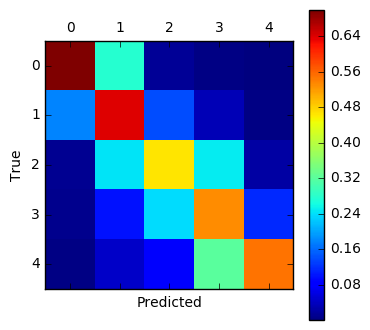

In [42]:
sum_rows = np.sum(best_confmat,axis=1)
nonzero_axis = [i for i in range(len(sum_rows)) if sum_rows[i] !=0]
scaled_confmat = best_confmat[nonzero_axis] / sum_rows[nonzero_axis,None]

plt.matshow(scaled_confmat)
plt.colorbar()
tick_marks = np.arange(total_bins)
plt.xticks(tick_marks, range(total_bins))
plt.yticks(tick_marks,nonzero_axis)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
## Setup test set

input_name_test = name_padded_test
input_itemdesc_test = itemdesc_padded_test
input_brand_test = test_raw.brand_name_inds.values.reshape((-1,1))
input_cat1_test = test_raw.cat1_inds.values.reshape((-1,1))
input_cat2_test = test_raw.cat2_inds.values.reshape((-1,1))
input_cat3_test = test_raw.cat3_inds.values.reshape((-1,1))
input_itemcond_test = test_raw.item_condition_id.values.reshape((-1,1))
input_ship_test = test_raw.shipping.values.reshape((-1,1))

temp_set_test = np.concatenate((input_name_test, input_itemdesc_test,input_cat1_test,input_cat2_test,input_cat3_test,
                                input_brand_test, input_itemcond_test, 
                                input_ship_test),axis = 1) #name_and_desc ,input_itemcond,input_shipping



In [ ]:
# test set too fat to just plug. consider batches
features_input_test = temp_set_test.astype(np.int32)

feat_placeholder_test = tf.placeholder(features_input_test.dtype, features_input_test.shape)
print('making tensor slices...')
dataset_test = tf.data.Dataset.from_tensor_slices(feat_placeholder_test)
print('making batches...')
dataset_test = dataset_test.batch(10000) 
iterator_test = dataset_test.make_initializable_iterator()
next_batch_test = iterator_test.get_next()

tot_runs = np.ceil(features_input_test.shape[0]/10000)

In [ ]:
## run on test set
with tf.Session() as sess:
    all_preds = []
    sess.run(iterator_test.initializer, {feat_placeholder_test: features_input_test}) 
    saver.restore(sess=sess, save_path=export_dir)
    for _ in range(int(tot_runs)):
        feed_x = sess.run(next_batch_test)
        predictions_final = sess.run(predictions, {input_x: feed_x, dropout_keep_prob: 1})
        all_preds.extend(predictions_final)
    

In [ ]:
a = np.array(all_preds)
print(a.shape)
b = np.argmax(a, axis = 1)

c = [sum(b==i) for i in set(b)]
print(c)

In [ ]:
set(b)